# Movies recommendation with Azure Open AI & Azure Cognitive Search
## Part 2: search examples


<img src="https://github.com/retkowsky/images/blob/master/movies_search.png?raw=true">

In [1]:
# %pip install azure-search-documents --pre --upgrade

In [2]:
# %pip install youtube-search-python

In [3]:
import gradio as gr
import json
import movieposters as mp
import openai
import os
import pytz
import re
import requests
import sys
import time

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import Vector

from datetime import datetime
from dotenv import load_dotenv
from IPython.display import IFrame, display
from io import BytesIO
from PIL import Image
from youtubesearchpython import VideosSearch, Comments

In [4]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [5]:
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
print("Local time:", datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S"))

Local time: 04-Sep-2023 13:02:55


In [6]:
print("Open AI version:", openai.__version__)

Open AI version: 0.27.9


In [7]:
load_dotenv("azure.env")

openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

acs_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
acs_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")

In [8]:
# Azure Open AI embeddings model to use
embeddings_engine = "text-embedding-ada-002"

- Vector search is in public preview
- Model name: text-embedding-ada-002
- Model version: 2
- API version: 2023-05-15

In [9]:
# Azure Cognitive Search index name to create
index_name = "moviereview"

## 1. Functions

In [10]:
def acs_delete_index(index_name):
    """
    Deleting an Azure Cognitive Search index
    Input: an Azure Cognitive Search index name
    """
    start = time.time()
    search_client = SearchIndexClient(
        endpoint=acs_endpoint, credential=AzureKeyCredential(acs_key)
    )
    
    try:
        print("Deleting the Azure Cognitive Search index:", index_name)
        search_client.delete_index(index_name)
        print("Done. Elapsed time:", round(time.time() - start, 2), "secs")
    except:
        print("Cannot delete index. Check the index name.")


In [11]:
def acs_index_stats(index_name):
    """
    Get statistics about Azure Cognitive Search index
    Input: an Azure Cognitive Search index name
    """
    url = (
        acs_endpoint
        + "/indexes/"
        + index_name
        + "/stats?api-version=2021-04-30-Preview"
    )
    headers = {
        "Content-Type": "application/json",
        "api-key": acs_key,
    }
    response = requests.get(url, headers=headers)
    print("Azure Cognitive Search index status for:", index_name, "\n")

    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))
        document_count = res["documentCount"]
        storage_size = res["storageSize"]

    else:
        print("Request failed with status code:", response.status_code)

    return document_count, storage_size

In [12]:
def acs_index_status(index_name):
    """
    Azure Cognitive Search index status
    Input: an Azure Cognitive Search index name
    """
    print("Azure Cognitive Search Index:", index_name, "\n")

    headers = {"Content-Type": "application/json", "api-key": acs_key}
    params = {"api-version": "2021-04-30-Preview"}
    index_status = requests.get(
        acs_endpoint + "/indexes/" + index_name, headers=headers, params=params
    )

    try:
        print(json.dumps((index_status.json()), indent=5))
    except:
        print("Request failed with status code:", response.status_code)

In [13]:
def openai_text_embeddings(text):
    """
    Generating embeddings from text using Azure Open AI
    Input: a text
    Output: a vector embedding made by Azure Open AI
    """
    embeddings = openai.Embedding.create(
        input=text,
        deployment_id=embeddings_engine,
    )
    embeddings = embeddings["data"][0]["embedding"]

    return embeddings

In [14]:
def get_list(movielist, disp=True):
    """
    Extract movies from a list of movies
    Input: movies list (list)
    Output: Numbered list (string)
    """
    pattern = r"\d+\.\s(.+)"
    matches = re.findall(pattern, movielist)
    for idx, movie in enumerate(matches, start=1):
        if disp:
            print(f"Movie {idx}: {movie}.")

    return matches

In [15]:
acs_index_status(index_name)

Azure Cognitive Search Index: moviereview 

{
     "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DBAA0BED295DB4\"",
     "name": "moviereview",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "imdb_id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "sortable": true,
               "facetable": true,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "title",
               "type": "Edm.String",
               "searchable": true,
               "filterable": true,
               "retrievable": true,
               "sortable": false,
               "facetable": f

In [16]:
document_count, storage_size = acs_index_stats(index_name)

Azure Cognitive Search index status for: moviereview 

{
  "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 10784,
  "storageSize": 564466206
}


In [17]:
print("Number of documents in the index =", f"{document_count:,}")
print("Size of the index =", round(storage_size / (1024 * 1024), 2), "MB")

Number of documents in the index = 10,784
Size of the index = 538.32 MB


In [18]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Get documents

In [19]:
def acs_get_documents(imdbid):
    """
    Get document by its id number
    Input: an imdbid (string)
    Output: results (string)
    """
    search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))
    result = search_client.get_document(key=imdbid)

    print("\033[1;31;34m")
    print("Movies:", result["title"])
    print("\033[1;31;32m")
    print("IMDB ID:", result["imdb_id"])
    print("Casting:", result["cast"])
    print("Director:", result["director"])
    print("Description:", result["description"])
    print("Genres:", result["genres"])
    print("Year:", result["year"])
    print("\033[0m")

In [20]:
acs_get_documents("tt0070328")


Movies: Live and Let Die

IMDB ID: tt0070328
Casting: Roger Moore Yaphet Kotto Jane Seymour Clifton James Julius Harris
Director: Guy Hamilton
Description: James Bond must investigate a mysterious murder case of a British agent in New Orleans. Soon he finds himself up against a gangster boss named Mr. Big.
Genres: Adventure Action Thriller
Year: 1973



### Simple query

In [21]:
def acs_full_query(query, nb=5):
    """
    Full text search using Azure Cognitive Search
    Input: a query (string)
    Output: results (text)
    """
    search_client = SearchClient(
        acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
    )

    results = search_client.search(search_text=query)
    
    idx = 1
    for result in results:
        if idx <= nb:
            print("\033[1;31;34m")
            print(result["title"])
            print("\033[1;31;32m")
            print("IMDB ID:", result["imdb_id"])
            print("Casting:", result["cast"])
            print("Director:", result["director"])
            print("Description:", result["description"])
            print("Genres:", result["genres"])
            print("Year:", result["year"])
            print("\033[0m")
            idx += 1

In [22]:
acs_full_query("Terminator", nb=5)


The Terminator

IMDB ID: tt0088247
Casting: Arnold Schwarzenegger Michael Biehn Linda Hamilton Paul Winfield Lance Henriksen
Director: James Cameron
Description: In the post-apocalyptic future reigning tyrannical supercomputers teleport a cyborg assassin known as the "Terminator" back to 1984 to kill Sarah Connor whose unborn son is destined to lead insurgents against 21st century mechanical hegemony. Meanwhile the human-resistance movement dispatches a lone warrior to safeguard Sarah. Can he stop the virtually indestructible killing machine?
Genres: Action Thriller Science Fiction
Year: 1984


Terminator 2 Judgment Day

IMDB ID: tt0103064
Casting: Arnold Schwarzenegger Linda Hamilton Edward Furlong Robert Patrick Earl Boen
Director: James Cameron
Description: Nearly 10 years have passed since Sarah Connor was targeted for termination by a cyborg from the future. Now her son John the future leader of the resistance is the target for a newer more deadly terminator. Once again the resis

## 3. Pure Vector Search

In [23]:
def acs_vectorsearch_query(query, topn=5):
    """
    Find movies from Azure Cognitive Search using the embedding overview field
    Pure Vector Search
    Input: a query (string)
    Output: results (list)
    """
    start = time.time()
    search_client = SearchClient(
        acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
    )

    vector = Vector(
        value=openai_text_embeddings(query), k=topn, fields="embed_overview"
    )

    results = search_client.search(
        search_text=None,
        vectors=[vector],
        select=["imdb_id", "title", "cast", "director", "description", "genres", "year"],
    )

    movies_list = []

    idx = 1
    for result in results:
        print("\033[1;31;34m")
        print(f"{idx} Movie title: {result['title']}")
        print("IMDB ID:", result["imdb_id"])
        print("\033[1;31;32m")
        print(f"Description: {result['description']}")
        print("\033[0m")
        print(f"Cast: {result['cast']}")
        print(f"Director: {result['director']}")
        print(f"Genres: {result['genres']}")
        print(f"Year: {result['year']}")
        print("\033[1;31;35m")
        print(f"Score = {result['@search.score']}")
        idx += 1

        movies_list.append(result["title"])

    elapsed = time.time() - start
    print("\033[0m")
    print(
        "\nElapsed time: "
        + time.strftime(
            "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
        )
    )

    return movies_list

**Multi-lingual search**. Use a multi-lingual embeddings model to represent your document in multiple languages in a single vector space to find documents regardless of the language they are in.


In [24]:
acs_vectorsearch_query("Je veux regarder un James Bond")


1 Movie title: Live and Let Die
IMDB ID: tt0070328

Description: James Bond must investigate a mysterious murder case of a British agent in New Orleans. Soon he finds himself up against a gangster boss named Mr. Big.

Cast: Roger Moore Yaphet Kotto Jane Seymour Clifton James Julius Harris
Director: Guy Hamilton
Genres: Adventure Action Thriller
Year: 1973

Score = 0.84836674

2 Movie title: You Only Live Twice
IMDB ID: tt0062512

Description: A mysterious space craft kidnaps a Russian and American space capsule and brings the world on the verge of another World War. James Bond investigates the case in Japan and meets with his archenemy Blofeld. The fifth film from the legendary James Bond series starring Sean Connery as the British super agent.

Cast: Sean Connery Akiko Wakabayashi Karin Dor Mie Hama TetsurÅ Tamba
Director: Lewis Gilbert
Genres: Action Thriller Adventure
Year: 1967

Score = 0.84705675

3 Movie title: GoldenEye
IMDB ID: tt0113189

Description: James Bond must unmask th

['Live and Let Die',
 'You Only Live Twice',
 'GoldenEye',
 'Licence to Kill',
 'Never Say Never Again']

In [25]:
acs_vectorsearch_query("I want some musical movies")


1 Movie title: Fantasia 2000
IMDB ID: tt0120910

Description: An update of the original film with new interpretations of great works of classical music.

Cast: Steve Martin Quincy Jones Bette Midler James Earl Jones Penn Jillette
Director: Paul Brizzi Hendel Butoy Francis Glebas Eric Goldberg Don Hahn Pixote Hunt James Algar GaÃ«tan Brizzi
Genres: Music Animation Family Fantasy
Year: 1999

Score = 0.86541647

2 Movie title: Stage Fright
IMDB ID: tt2190838

Description: A snobby musical theater camp is terrorized by a blood-thirsty killer who hates musical theater.

Cast: Minnie Driver Meat Loaf Allie MacDonald Douglas Smith Kent Nolan
Director: Jerome Sable
Genres: Horror
Year: 2014

Score = 0.8530216

3 Movie title: Northern Soul
IMDB ID: tt1837613

Description: Set in 1974 an authentic and uplifting tale of two friends whose horizons are opened up by the discovery of black American soul music.

Cast: Steve Coogan Antonia Thomas Christian McKay Ricky Tomlinson James Lance
Director: E

['Fantasia 2000', 'Stage Fright', 'Northern Soul', 'Thin Ice', 'Flashdance']

## 4. Multiple search queries with Azure Cognitive Search

### 4.1 Multi-Vector search

**Multi-query vector search** sends **multiple queries across multiple vector fields** in your search index. This query example looks for similarity in both embed_title and embed_overview, but sends in two different query embeddings respectively. This scenario is ideal for multi-modal use cases where you want to search over a textVector field and an imageVector field. You can also use this scenario if you have different embedding models with different dimensions in your search index. This also displays scores using Reciprocal Rank Fusion (RRF).

In [26]:
start = time.time()

query = "I want to watch a film about a sinking ship"

search_client = SearchClient(
    acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
)

vector1 = Vector(value=openai_text_embeddings(query), k=5, fields="embed_title")
vector2 = Vector(value=openai_text_embeddings(query), k=5, fields="embed_overview")

results = search_client.search(
    search_text=None,
    vectors=[vector1, vector2],
    select=["imdb_id", "title", "cast", "director", "description", "genres", "year"],
)

idx = 1
for result in results:
    print("\033[1;31;34m")
    print(f"{idx} Movie title: {result['title']}")
    print("IMDB ID:", result["imdb_id"])
    print("\033[1;31;32m")
    print(f"Description: {result['description']}")
    print("\033[0m")
    print(f"Cast: {result['cast']}")
    print(f"Director: {result['director']}")
    print(f"Genres: {result['genres']}")
    print(f"Year: {result['year']}")
    print("\033[1;31;35m")
    print(f"Score = {result['@search.score']}")
    idx += 1

elapsed = time.time() - start
print("\033[0m")
print(
    "\nElapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)


1 Movie title: Titanic
IMDB ID: tt0115392

Description: A story of the romances of two couples upon the doomed ship. Isabella Paradine (Catherine Zeta Jones) is a wealthy woman mourning the loss of her aunt who reignites a romance with old flame Wynn Park (Peter Gallagher). Meanwhile a charming ne'er do well named Jamie Perse (Mike Doyle) steals a ticket for the ship and falls for a sweet innocent Irish girl on board. But their romance is threatened by the villainous Simon Doonan (Tim Curry) who has discovered about the ticket and makes Jamie his unwilling accomplice as well as having sinister plans for the girl.

Cast: Peter Gallagher George C. Scott Catherine Zeta-Jones Eva Marie Saint Tim Curry
Director: Robert Lieberman
Genres: Action Drama Romance
Year: 1996

Score = 0.01666666753590107

2 Movie title: Black Sea
IMDB ID: tt2261331

Description: A suspenseful adventure thriller directed by Academy Award winner Kevin Macdonald centering on a rogue submarine captain who pulls togeth

## 4.2 Cross-field vector search

A **cross-field vector query** sends a **single query across multiple vector fields in your search index**. This query example looks for similarity in both "embed_title" and "embed_overview" and displays scores using **Reciprocal Rank Fusion (RRF)**.

For hybrid search scoring, Cognitive Search uses Reciprocal Rank Fusion (RRF). In information retrieval, RRF combines the results of different search methods to produce a single, more accurate and relevant result. (Here, a search method refers to methods such as vector search and full-text search.) RRF is based on the concept of reciprocal rank, which is the inverse of the rank of the first relevant document in a list of search results. 

At a basic level, RRF works by taking the search results from multiple methods, assigning a reciprocal rank score to each document in the results, and then combining these scores to create a new ranking. The main idea behind this method is that documents appearing in the top positions across multiple search methods are likely to be more relevant and should be ranked higher in the combined result.

In [27]:
start = time.time()

query = "show me a film that talks about some rock bands"

search_client = SearchClient(
    acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
)

vector = Vector(
    value=openai_text_embeddings(query), k=5, fields="embed_title, embed_overview"
)

results = search_client.search(
    search_text=None,
    vectors=[vector],
    select=["imdb_id", "title", "cast", "director", "description", "genres", "year"],
)

idx = 1
for result in results:
    print("\033[1;31;34m")
    print(f"{idx} Movie title: {result['title']}")
    print("IMDB ID:", result["imdb_id"])
    print("\033[1;31;32m")
    print(f"Description: {result['description']}")
    print("\033[0m")
    print(f"Cast: {result['cast']}")
    print(f"Director: {result['director']}")
    print(f"Genres: {result['genres']}")
    print(f"Year: {result['year']}")
    print("\033[1;31;35m")
    print(f"Score = {result['@search.score']}")
    idx += 1

elapsed = time.time() - start
print("\033[0m")
print(
    "\nElapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)


1 Movie title: The Buddy Holly Story
IMDB ID: tt0077280

Description: A film about the life and career of the early rock and roll star.

Cast: Gary Busey Don Stroud Charles Martin Smith Conrad Janis William Jordan
Director: Steve Rash
Genres: Drama
Year: 1978

Score = 0.01666666753590107

2 Movie title: Rock 'n' Roll High School
IMDB ID: tt0079813

Description: A group of rock-music-loving students with the help of the Ramones take over their school to combat its newly installed oppressive administration.

Cast: P.J. Soles Vince Van Patten Clint Howard Mary Woronov Dey Young
Director: Allan Arkush
Genres: Comedy Music
Year: 1979

Score = 0.01666666753590107

3 Movie title: The Last Waltz
IMDB ID: tt0077838

Description: Martin Scorsese's rockumentary intertwines footage from "The Band's" incredible farewell tour with probing backstage interviews and featured performances by Eric Clapton Bob Dylan Joni Mitchell Ringo Starr and other rock legends.

Cast: Robbie Robertson Rick Danko Levo

## 4.3 Pure vector search with filter
We can specify a filter on the vector search

In [28]:
myfilter = "director eq 'James Cameron'"
myfilter

"director eq 'James Cameron'"

In [29]:
start = time.time()

query = "show me a movie about a robot"

search_client = SearchClient(
    acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
)

vector = Vector(value=openai_text_embeddings(query), k=5, fields="embed_overview")

results = search_client.search(
    search_text=None,
    vectors=[vector],
    filter=myfilter,
    select=["imdb_id", "title", "cast", "director", "description", "genres", "year"],
)

idx = 1
for result in results:
    print("\033[1;31;34m")
    print(f"{idx} Movie title: {result['title']}")
    print("IMDB ID:", result["imdb_id"])
    print("\033[1;31;32m")
    print(f"Description: {result['description']}")
    print("\033[0m")
    print(f"Cast: {result['cast']}")
    print(f"Director: {result['director']}")
    print(f"Genres: {result['genres']}")
    print(f"Year: {result['year']}")
    print("\033[1;31;35m")
    print(f"Score = {result['@search.score']}")
    idx += 1

elapsed = time.time() - start
print("\033[0m")
print(
    "\nElapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)


1 Movie title: The Terminator
IMDB ID: tt0088247

Description: In the post-apocalyptic future reigning tyrannical supercomputers teleport a cyborg assassin known as the "Terminator" back to 1984 to kill Sarah Connor whose unborn son is destined to lead insurgents against 21st century mechanical hegemony. Meanwhile the human-resistance movement dispatches a lone warrior to safeguard Sarah. Can he stop the virtually indestructible killing machine?

Cast: Arnold Schwarzenegger Michael Biehn Linda Hamilton Paul Winfield Lance Henriksen
Director: James Cameron
Genres: Action Thriller Science Fiction
Year: 1984

Score = 0.8407193


Elapsed time: 00:00:00.702397


## 4.4 Hybrid search

**Hybrid search consists of keyword queries and vector queries** in a single search request.

Vector search is implemented at the field level, which means you can build queries that include vector fields and searchable text fields. The queries execute in parallel and the results are merged into a single response. Optionally, add semantic search (preview) for even more accuracy with L2 reranking using the same language models that power Bing.

In [30]:
start = time.time()

query = "show me a film with Stallone"

search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))

vector = Vector(value=openai_text_embeddings(query), k=10, fields="embed_overview")

results = search_client.search(
    search_text=query,
    vectors=[vector],
    select=["imdb_id", "title", "cast", "director", "description", "genres", "year"],
    top=10,
)

idx = 1
for result in results:
    print("\033[1;31;34m")
    print(f"{idx} Movie title: {result['title']}")
    print("IMDB ID:", result["imdb_id"])
    print("\033[1;31;32m")
    print(f"Description: {result['description']}")
    print("\033[0m")
    print(f"Cast: {result['cast']}")
    print(f"Director: {result['director']}")
    print(f"Genres: {result['genres']}")
    print(f"Year: {result['year']}")
    print("\033[1;31;35m")
    print(f"Score = {result['@search.score']}")
    idx += 1

elapsed = time.time() - start
print("\033[0m")
print(
    "\nElapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)


1 Movie title: Paradise Alley
IMDB ID: tt0078056

Description: Sylvester Stallone is fighting the odds again this time in the wrestling ring. As Cosmo Carboni he and his two brothers dream of getting out of Hell's Kitchen (circa 1946) and into the big time. The exit signs point to Paradise Alley a sleazy private club where the floorshow consists of raucous wrestling matches with big purses. Stallone not only starred in and wrote this action-packed film he also made his directorial debut in this tale of three guys who could take anything Hell's Kitchen could dish out.

Cast: Sylvester Stallone Lee Canalito Armand Assante Frank McRae Anne Archer
Director: Sylvester Stallone
Genres: Action Adventure Drama
Year: 1978

Score = 0.03333333507180214

2 Movie title: Stop Or My Mom Will Shoot
IMDB ID: tt0105477

Description: A tough cop's (Sylvester Stallone) seemingly frail mother (Estelle Getty) comes to stay with him and progressively interferes in his life. She buys him an illegal MAC-10 ma

## 4.5 Hybrid search with a filter

In [31]:
myfilter = "year eq '2000' or director eq 'William Friedkin'"

In [32]:
start = time.time()

query = "show me a movie"

search_client = SearchClient(acs_endpoint, index_name, AzureKeyCredential(acs_key))

vector = Vector(value=openai_text_embeddings(query), k=10, fields="embed_overview")

results = search_client.search(
    search_text=query,
    vectors=[vector],
    filter=myfilter,
    select=["imdb_id", "title", "cast", "director", "description", "genres", "year"],
    top=10,
)

idx = 1
for result in results:
    print("\033[1;31;34m")
    print(f"{idx} Movie title: {result['title']}")
    print("IMDB ID:", result["imdb_id"])
    print("\033[1;31;32m")
    print(f"Description: {result['description']}")
    print("\033[0m")
    print(f"Cast: {result['cast']}")
    print(f"Director: {result['director']}")
    print(f"Genres: {result['genres']}")
    print(f"Year: {result['year']}")
    print("\033[1;31;35m")
    print(f"Score = {result['@search.score']}")
    idx += 1

elapsed = time.time() - start
print("\033[0m")
print(
    "\nElapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)


1 Movie title: Scary Movie
IMDB ID: tt0175142

Description: Following on the heels of popular teen-scream horror movies with uproarious comedy and biting satire. Marlon and Shawn Wayans Shannon Elizabeth and Carmen Electra pitch in to skewer some of Hollywood's biggest blockbusters including Scream I Know What You Did Last Summer The Matrix American Pie and The Blair Witch Project.

Cast: Carmen Electra Dave Sheridan Anna Faris Jon Abrahams Regina Hall
Director: Keenen Ivory Wayans
Genres: Comedy
Year: 2000

Score = 0.03125763311982155

2 Movie title: State and Main
IMDB ID: tt0120202

Description: A Hollywood Film unit invades a small Vermont town leading to wholesale abandonment of values and virtue. A smart warm and funny movie - and not just for movie buffs. Tagline: When a film crew came to Waterford Vermont - They Shot First And Asked Questions Later.

Cast: Alec Baldwin Philip Seymour Hoffman William H. Macy Sarah Jessica Parker Julia Stiles
Director: David Mamet
Genres: Comedy

# 4.6 Semantic Hybrid Search

In [33]:
query = "show me rommmantttic movies"

search_client = SearchClient(
    acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
)

vector = Vector(value=openai_text_embeddings(query), k=5, fields="embed_overview")

results = search_client.search(  
    search_text=query,  
    vectors=[vector],
    select = ["imdb_id", "title", "cast", "director", "description", "genres", "year"],
    query_type="semantic", query_language="en-us", semantic_configuration_name='my-semantic-config',
    query_caption="extractive", query_answer="extractive",
)

semantic_answers = results.get_answers()
for answer in semantic_answers:
    if answer.highlights:
        print(f"Semantic Answer: {answer.highlights}")
    else:
        print(f"Semantic Answer: {answer.text}")
    print(f"Semantic Answer Score: {answer.score}\n")

idx = 1
for result in results:
    if idx <= 10:
        print("\033[1;31;34m")
        print(f"{idx} Movie title: {result['title']}")
        print("IMDB ID:", result["imdb_id"])
        print("\033[1;31;32m")
        print(f"Description: {result['description']}")
        print("\033[0m")
        print(f"Genres: {result['genres']}")
        print("\033[1;31;35m")
        print(f"Score = {result['@search.score']}")
        idx += 1


1 Movie title: The Tourist
IMDB ID: tt1243957

Description: American tourist Frank (Johnny Depp) meets mysterious British woman Elsie (Angelina Jolie) on the train to Venice. Romance seems to bud but there's more to her than meets the eye. Remake of the 2005 French film "Anthony Zimmer" written and directed by JÃ©rÃ´me Salle.

Genres: Action Thriller Romance

Score = 0.010526316240429878

2 Movie title: Before Sunrise
IMDB ID: tt0112471

Description: A dialogue marathon of a film this fairytale love story of an American boy and French girl. During a day and a night together in Vienna their two hearts collide.

Genres: Drama Romance

Score = 0.015625

3 Movie title: Waiting for Forever
IMDB ID: tt1296898

Description: A Hollywood-set romantic tale of a guy who is content to live his life without a job yet with the love of his life a young actress.

Genres: Drama Romance

Score = 0.01666666753590107

4 Movie title: Midnight in Paris
IMDB ID: tt1605783

Description: A romantic comedy abo

## 5. ChatGPT and Azure Cognitive Search

**temperature** controls the "creativity" of the generated text, between 0 and 2. A higher temperature will result in more diverse and unexpected responses, while a lower temperature will result in more conservative and predictable responses. The default value for temperature is 1.0, but you can experiment with different values to see what works best for your use case. Higher values means the model will take more risks. Try 0.9 for more creative applications, and 0 (argmax sampling) for ones with a well-defined answer. We generally recommend altering this or top_p but not both.

**top_p** - An alternative to sampling with temperature, called nucleus sampling, where the model considers the results of the tokens with top_p probability mass. 1 is the default value. So 0.1 means only the tokens comprising the top 10% probability mass are considered. We generally recommend altering this or temperature but not both.

In [34]:
def azure_chatgpt_movies(prompt, max_retries=3, retry_delay=1):
    """
    Chat GPT with Azure Open AI
    Input: prompt (text)
    Output: results (text)
    """
    for _ in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                engine="gpt-35-turbo",  # Should be deployed in the AOAI studio
                messages=[
                    {
                        "role": "system",
                        "content": "You are an AI assistant that helps people to find \
                        information about movies."
                    },
                    {"role": "user", "content": prompt},
                ],
                temperature=0.9,
                max_tokens=400,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0,
                stop=None,
            )

            resp = response["choices"][0]["message"]["content"]

            print("\033[1;31;34mPrompt:", prompt)
            print("\n\033[1;31;32mResponse:", resp)
            print("\033[1;31;35m")
            print("Powered by Azure AI")
            # Local time
            local_tz = pytz.timezone(
                requests.get("https://ipinfo.io").json()["timezone"]
            )
            print(datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S"))

            return resp

        except Exception as e:
            print("Error:", str(e))
            print("Retrying...")
            time.sleep(retry_delay)

    print("Maximum retries exceeded. Unable to get a response.")

    return None

In [35]:
def get_movie_poster(imdb_id):
    """
    Display movie poster from its IMDB id
    Input: imdb_id (text)
    Output: PIL Image and saved image
    """
    poster = mp.get_poster(id=imdb_id)
    response = requests.get(poster)

    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        display(img)
        # Save as a local file
        os.makedirs("movieposter", exist_ok=True)
        posterfile = os.path.join("movieposter", "movie_" + str(imdb_id) + ".jpg")
        img.save(posterfile)
    else:
        print("Failed to fetch the movie image.")

In [36]:
def get_trailer(movietitle):
    """
    Get youtube video trailer from its title
    Input: movie title (string)
    Output: Display the movie trailer video
    """
    # Search video on youtube
    videosSearch = VideosSearch(movietitle, limit=1)
    video_results = videosSearch.result().get("result")

    if video_results:
        print("\033[1;31;34m")
        video_id = video_results[0].get("id")
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        print("\033[1;31;34m", video_url)
        vid = IFrame(
            src=f"https://www.youtube.com/embed/{video_id}", width="560", height="315"
        )
        display(vid)

        # Get the first 20 Youtube video comments
        print("YouTube video comments for", movietitle, ":")
        comments = Comments.get(video_id)
        print("\033[1;31;32m")

        for idx, comment in enumerate(comments.get("result")):
            print(f"Comment {idx+1:02}: {comment.get('content')}")
        print("\033[0m")
    else:
        print("No video found on YouTube.")

In [37]:
def get_all_trailers(movies_list):
    """
    Get movie trailers from a list of movies
    Input: movies list (list)
    Output: vDisplay the video files and saved them
    """
    for movie in movies_list:
        print(movie)
        try:
            get_trailer(movie)
        except:
            print("Error")
        print()

In [38]:
def acs_find_movies_with_posters(title):
    """
    Cross Field Search using Azure Cognitive Search
    Input: movie title (string)
    Output: results (text)
    """
    search_client = SearchClient(
        acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
    )

    vector = Vector(value=openai_text_embeddings(title), k=1, fields="embed_title")

    results = search_client.search(
        search_text=None,
        vectors=[vector],
        select=[
            "imdb_id",
            "title",
            "cast",
            "director",
            "description",
            "genres",
            "year",
        ],
        top=1,
    )

    for result in results:
        if result['@search.score'] >= 0.9:
            print("\033[1;31;34m")
            print(f"Movie title: {result['title']}")
            print(f"IMDB ID: {result['imdb_id']}")
            # Get movie poster
            get_movie_poster(result["imdb_id"])
            print("\033[1;31;32m")
            print(f"Description: {result['description']}")
            print("\033[0m")
            print(f"Cast: {result['cast']}")
            print(f"Director: {result['director']}")
            print(f"Genres: {result['genres']}")
            print(f"Year: {result['year']}")
            print("\033[1;31;35m")
            print(f"Score = {result['@search.score']}")
        else:
            print("Note: The movie", title, "is not available in the Azure Cognitive search index")

In [39]:
def get_acs_movies_results(movies_list):
    """
    Find movies using Azure Cognitive Search from a list of movies
    Input: movies list (list)
    Output: run the acs_find_movies_with_posters function on all element of the input list
    """
    for movie in movies_list:
        acs_find_movies_with_posters(movie)

### Tests

In [40]:
azure_chatgpt_movies("Who are you?")

Prompt: Who are you?

Response: I am an AI assistant designed to help you find information about movies. You can ask me questions about movies, actors, directors, release dates, ratings, reviews, and more. I'm here to make your movie watching experience even better!

Powered by Azure AI
04-Sep-2023 13:03:14


"I am an AI assistant designed to help you find information about movies. You can ask me questions about movies, actors, directors, release dates, ratings, reviews, and more. I'm here to make your movie watching experience even better!"

In [41]:
azure_chatgpt_movies("Can you display the name of the actors and characters of the Titanic movie in a json list?")

Prompt: Can you display the name of the actors and characters of the Titanic movie in a json list?

Response: Sure, here is a JSON list of the main actors and their characters from the movie Titanic:

```json
[
  {
    "actor": "Leonardo DiCaprio",
    "character": "Jack Dawson"
  },
  {
    "actor": "Kate Winslet",
    "character": "Rose DeWitt Bukater"
  },
  {
    "actor": "Billy Zane",
    "character": "Caledon \"Cal\" Hockley"
  },
  {
    "actor": "Kathy Bates",
    "character": "Molly Brown"
  },
  {
    "actor": "Frances Fisher",
    "character": "Ruth DeWitt Bukater"
  },
  {
    "actor": "Gloria Stuart",
    "character": "Old Rose"
  },
  {
    "actor": "Bill Paxton",
    "character": "Brock Lovett"
  },
  {
    "actor": "Bernard Hill",
    "character": "Captain Edward J. Smith"
  }
]
```

Let me know if you need anything else!

Powered by Azure AI
04-Sep-2023 13:03:23


'Sure, here is a JSON list of the main actors and their characters from the movie Titanic:\n\n```json\n[\n  {\n    "actor": "Leonardo DiCaprio",\n    "character": "Jack Dawson"\n  },\n  {\n    "actor": "Kate Winslet",\n    "character": "Rose DeWitt Bukater"\n  },\n  {\n    "actor": "Billy Zane",\n    "character": "Caledon \\"Cal\\" Hockley"\n  },\n  {\n    "actor": "Kathy Bates",\n    "character": "Molly Brown"\n  },\n  {\n    "actor": "Frances Fisher",\n    "character": "Ruth DeWitt Bukater"\n  },\n  {\n    "actor": "Gloria Stuart",\n    "character": "Old Rose"\n  },\n  {\n    "actor": "Bill Paxton",\n    "character": "Brock Lovett"\n  },\n  {\n    "actor": "Bernard Hill",\n    "character": "Captain Edward J. Smith"\n  }\n]\n```\n\nLet me know if you need anything else!'

In [42]:
azure_chatgpt_movies("When was made the Titanic movie?")

Prompt: When was made the Titanic movie?

Response: The movie Titanic was released in 1997.

Powered by Azure AI
04-Sep-2023 13:03:24


'The movie Titanic was released in 1997.'

In [43]:
azure_chatgpt_movies("Who is the director of the shining? What was the release year?")

Prompt: Who is the director of the shining? What was the release year?

Response: The director of The Shining is Stanley Kubrick and it was released in 1980.

Powered by Azure AI
04-Sep-2023 13:03:24


'The director of The Shining is Stanley Kubrick and it was released in 1980.'

In [44]:
azure_chatgpt_movies("What are the main characters of Million Dollar Baby? Who is the director? What is the release year?")

Prompt: What are the main characters of Million Dollar Baby? Who is the director? What is the release year?

Response: The main characters of Million Dollar Baby are Maggie Fitzgerald (played by Hilary Swank), Frankie Dunn (played by Clint Eastwood), and Eddie "Scrap-Iron" Dupris (played by Morgan Freeman). Clint Eastwood is also the director of the movie. The movie was released in 2004.

Powered by Azure AI
04-Sep-2023 13:03:26


'The main characters of Million Dollar Baby are Maggie Fitzgerald (played by Hilary Swank), Frankie Dunn (played by Clint Eastwood), and Eddie "Scrap-Iron" Dupris (played by Morgan Freeman). Clint Eastwood is also the director of the movie. The movie was released in 2004.'

In [45]:
azure_chatgpt_movies("Share with me some details about the 'Les choses de la vie' movie")

Prompt: Share with me some details about the 'Les choses de la vie' movie

Response: "Les choses de la vie" is a French drama film that was released in 1970. The movie is directed by Claude Sautet and stars Michel Piccoli, Romy Schneider, and Lea Massari in the lead roles. The story revolves around a man named Pierre, who is involved in a car accident and reflects on his past relationships and choices while lying in the hospital. The film explores the themes of love, regret, and the choices we make in life. It received critical acclaim upon its release and is considered a classic of French cinema.

Powered by Azure AI
04-Sep-2023 13:03:31


'"Les choses de la vie" is a French drama film that was released in 1970. The movie is directed by Claude Sautet and stars Michel Piccoli, Romy Schneider, and Lea Massari in the lead roles. The story revolves around a man named Pierre, who is involved in a car accident and reflects on his past relationships and choices while lying in the hospital. The film explores the themes of love, regret, and the choices we make in life. It received critical acclaim upon its release and is considered a classic of French cinema.'

## 6. ChatGPT and Azure Cognitive Search and additional results (trailers)

### Test 1

In [46]:
prompt = "I want to see an action movie from the 70's in New York City.\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: I want to see an action movie from the 70's in New York City. I want you to save only the movie title in a numbered list with the release year.

Response: Sure thing! Here are some action movies from the 70s set in New York City:
1. The French Connection (1971)
2. Across 110th Street (1972)
3. The Taking of Pelham One Two Three (1974)
4. Death Wish (1974)
5. The Warriors (1979)

Which one of these movies would you like to watch?

Powered by Azure AI
04-Sep-2023 13:03:34


In [47]:
movies_list = get_list(answer)

Movie 1: The French Connection (1971).
Movie 2: Across 110th Street (1972).
Movie 3: The Taking of Pelham One Two Three (1974).
Movie 4: Death Wish (1974).
Movie 5: The Warriors (1979).



Movie title: The French Connection
IMDB ID: tt0067116


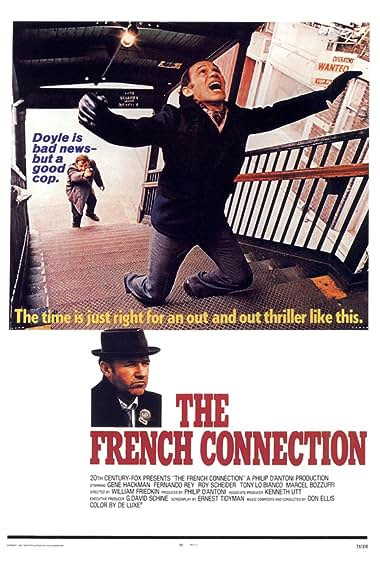


Description: Tough narcotics detective 'Popeye' Doyle is in hot pursuit of a suave French drug dealer who may be the key to a huge heroin-smuggling operation.

Cast: Gene Hackman Fernando Rey Roy Scheider Tony Lo Bianco Marcel Bozzuffi
Director: William Friedkin
Genres: Action Crime Thriller
Year: 1971

Score = 0.96069765

Movie title: Across 110th Street
IMDB ID: tt0068168


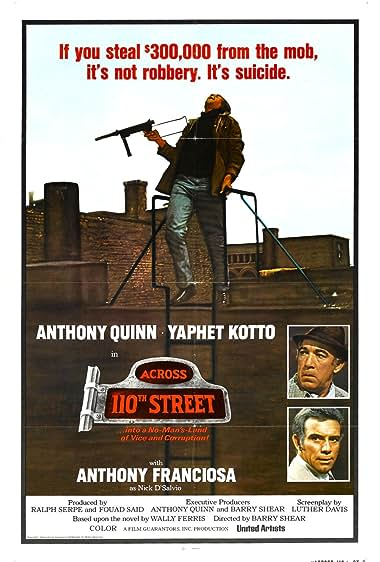


Description: In a daring robbery some 300 000 is taken from the Italian mob. Several mafiosi are killed as are two policemen. Lt. Pope and Mattelli are two New York City cops trying to break the case. Three small-time criminals are on the run with the money. Will the mafia catch them first or will the police? Written by Ken Miller

Cast: Anthony Quinn Yaphet Kotto Anthony Franciosa Antonio Fargas Gloria Hendry
Director: Barry Shear
Genres: Action Crime Drama Thriller
Year: 1972

Score = 0.95647305

Movie title: The Taking of Pelham One Two Three
IMDB ID: tt0072251


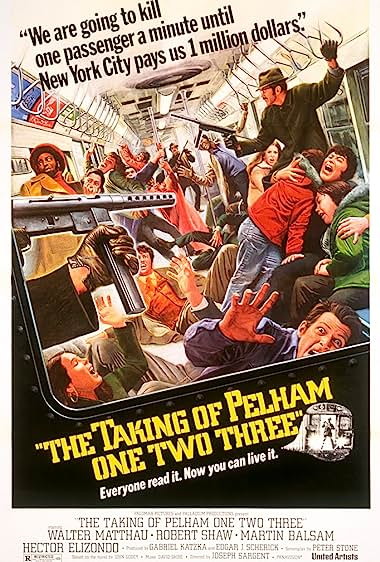


Description: In New York armed men hijack a subway car and demand a ransom for the passengers. Even if it's paid how could they get away?

Cast: Walter Matthau Robert Shaw Martin Balsam HÃ©ctor Elizondo Earl Hindman
Director: Joseph Sargent
Genres: Action Adventure Crime Thriller
Year: 1974

Score = 0.97160304

Movie title: Death Wish
IMDB ID: tt0071402


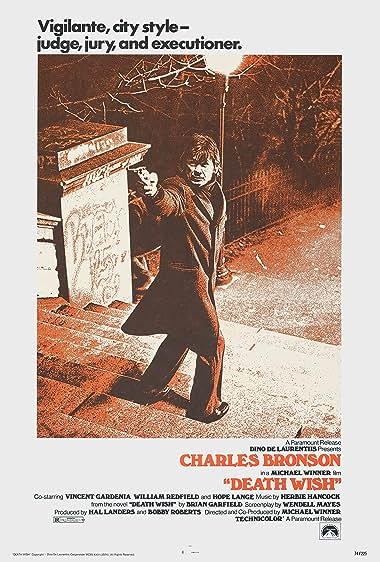


Description: A New York City architect becomes a one-man vigilante squad after his wife is murdered by street punks in which he randomly goes out and kills would-be muggers on the mean streets after dark.

Cast: Charles Bronson Hope Lange Vincent Gardenia Steven Keats William Redfield
Director: Michael Winner
Genres: Action Crime Drama Thriller
Year: 1974

Score = 0.94395405

Movie title: The Warriors
IMDB ID: tt0080120


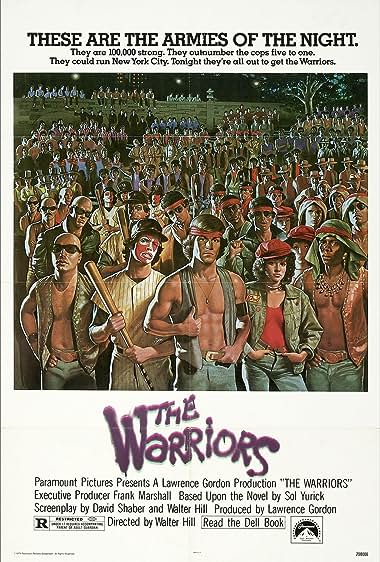


Description: Prominent gang leader Cyrus calls a meeting of New York's gangs to set aside their turf wars and take over the city. At the meeting a rival leader kills Cyrus but a Coney Island gang called the Warriors is wrongly blamed for Cyrus' death. Before you know it the cops and every gangbanger in town is hot on the Warriors' trail.

Cast: Michael Beck James Remar David Patrick Kelly Dorsey Wright David Harris
Director: Walter Hill
Genres: Action Adventure Crime Drama Thriller
Year: 1979

Score = 0.9266372


In [48]:
get_acs_movies_results(movies_list)

In [49]:
get_all_trailers(movies_list)

The French Connection (1971)

 https://www.youtube.com/watch?v=ncWxtpXn3gA


YouTube video comments for The French Connection (1971) :

Comment 01: The best part about older movies like this is the background scenario, as in the cars, the clothing people wore, ect.
Comment 02: This movie is still a hit even in 2022!
Comment 03: Rest in Peace to William Friedkin. He directed great films like this one, The Exorcist and Rules of Engagement, the war drama that had similar vibes to A Few Good Men
Comment 04: This film is stellar from start to finish. That best picture Oscar was well deserved!
Comment 05: RIP William Friedkin, your life's work was amazing and legendary, has been loved by many generations and will be loved by many more to come.
Comment 06: Great movie. But damn, this trailer is fantastic! The gritty gumshoe narrator, slick edits, tense score; did Freidkin himself make it? Loved it
Comment 07: The best car chase ever still love watching this film
Comment 08: The setting of this movie is a perfect storm of urban decay and now classic cars. This can neve

YouTube video comments for Across 110th Street (1972) :

Comment 01: Criminally underrated no holds barred classic. Required viewing for anyone wanting that raw 70’s inner city vibe 
Comment 02: Not only one of the most important Blaxploitation crossovers, but also this could be seen as the missing link between In The Heat Of The Night & Lethal Weapon. And yet, Across 110th Street remains arguably the most powerful of them all. An unflinching portrait of corruption within the police force, racial tension within the criminal underworld & love of money which connects both in ways that the very definition of "good guys & bad guys" is more blurred than ever before.
Comment 03: Just watched  again . About  10  times . Love it.paul Benjamin  steals the show . Great  actor
Comment 04: I watched this in Nairobi Kenya in 1989. It was an outstanding movie by the standards of those days
Comment 05: One of the grittiest and bleakest blaxploitation films from that era. Hands down.
Comment 06: One o

YouTube video comments for The Taking of Pelham One Two Three (1974) :

Comment 01: I could watch this movie every day and never get sick of it. Every single character, whether big or small, are all rememberable. Not nearly as celebrated as it deserves to be.
Comment 02: Just watched this film again at a revival house theater and it was great! I'd forgotten how entertaining and well written it was. All the actors were at the top of their game, and very well cast. The audience loved it! We all applauded at the films great ending, stayed through the end credits, and then applauded again. It truly captures NYC in the mid '70's so well, and opens your eyes to what crap most of todays movies really are.
Comment 03: One of the rare trailers from 70s America that doesn't spoil anything to the audience.
Comment 04: I saw this the other night on TCM.  I was shocked at how realistic the inter-character conversations were.  I was born in 1974 and I hope to watch this with my dad soon.
Comment 05:

YouTube video comments for Death Wish (1974) :

Comment 01: Charles Bronson casts back in the 70’s is my all time favourite vigilante hero in majority of the classics movies 
Comment 02: "Death Wish"(1974) is an excellent vigilante action thriller movie, and probably the best movie of all time for this Kind!
Comment 03: Love this!! Classic
Comment 04: this and the second of this saga for me are the best the others are violence without a good script.
Comment 05: classic
Comment 06: One of the best movies ever wayyy better than most movies today
Comment 07: Bronson pateando traseros en los 70s
Comment 08: New York needs about a hundred Mr. Kerseys’
Comment 09: A modern day classic!  I would encourage more of you to carry s gun, and use it responsibly to defend yourself and your local community.
Comment 10: "Now I'm going to Emmett's fix it shop, to fix Emmett"
Comment 11: 🍿
Comment 12: Rotten tomatoes please upload the trailer of Ninja Assassin (2009)


The Warriors (1979)

 https://www.

YouTube video comments for The Warriors (1979) :

Comment 01: This film is one of my family’s treasured favorites of all time. I never get tired of watching it. One year for Halloween my brothers and cousins were all Warriors, I was the only Baseball Furie!
Comment 02: Here in Spain the film was a clear reference for teenagers and twentish. Another vibrant American movie that made us dream of another way of living our european lives. In this side of the pool we were always surpass by the amount of physical violence shown in this type of films and the apparent simplicity to get weapons. The oozing of youth is constant and the end on the beach is memorable and the soundtrack adds rhythm and anxiety. A masterpiece, no doubt.
Comment 03: Hey Boppers, 
Comment 04: One of my ten favorite movies ever made. With self propelled surreal action that never slows down as The Warriors are constantly and relentlessly tracked and chased, trapped and assaulted from every angle.
Comment 05: It may not h

### Test 2

In [50]:
prompt = "What are the movies of Sylvester Stallone between 1985 and 1990?.\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: What are the movies of Sylvester Stallone between 1985 and 1990?. I want you to save only the movie title in a numbered list with the release year.

Response: Sure, here are the movies of Sylvester Stallone between 1985 and 1990:

1. "Rocky IV" (1985)
2. "Cobra" (1986)
3. "Over the Top" (1987)
4. "Rambo III" (1988)
5. "Lock Up" (1989)
6. "Tango & Cash" (1989)
7. "Rocky V" (1990)

Powered by Azure AI
04-Sep-2023 13:03:59


In [51]:
movies_list = get_list(answer)

Movie 1: "Rocky IV" (1985).
Movie 2: "Cobra" (1986).
Movie 3: "Over the Top" (1987).
Movie 4: "Rambo III" (1988).
Movie 5: "Lock Up" (1989).
Movie 6: "Tango & Cash" (1989).
Movie 7: "Rocky V" (1990).



Movie title: Rocky IV
IMDB ID: tt0089927


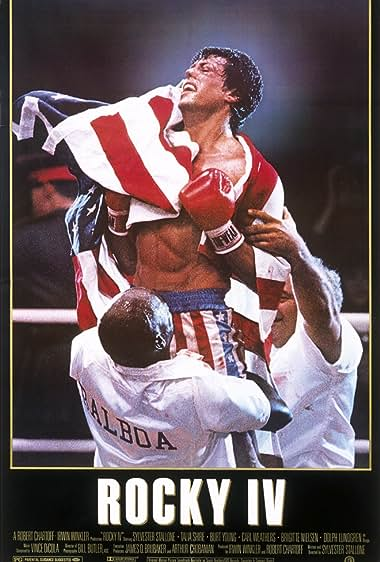


Description: Rocky must come out of retirement to battle a gargantuan Soviet fighter named Drago who brutally punished Rocky's friend and former rival Apollo Creed. Seeking revenge in the name of his fallen comrade and his country Rocky agrees to fight Drago in Moscow on Christmas and the bout changes both fighters -- and the world.

Cast: Sylvester Stallone Talia Shire Burt Young Carl Weathers Brigitte Nielsen
Director: Sylvester Stallone
Genres: Drama
Year: 1985

Score = 0.9462177

Movie title: Cobra
IMDB ID: tt0090859


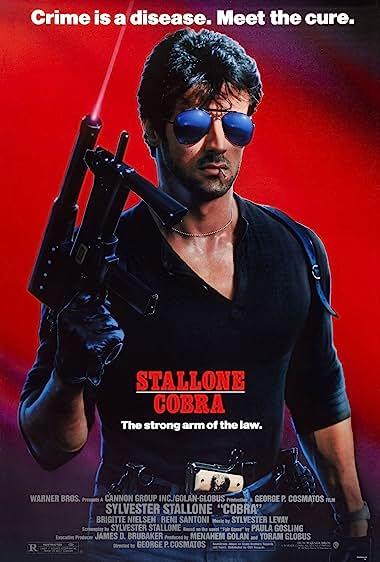


Description: A tough-on-crime street cop must protect the only surviving witness to a strange murderous cult with far reaching plans.

Cast: Sylvester Stallone Brigitte Nielsen Reni Santoni Brian Thompson Lee Garlington
Director: George P. Cosmatos
Genres: Action Crime Thriller
Year: 1986

Score = 0.9190714

Movie title: Over the Top
IMDB ID: tt0093692


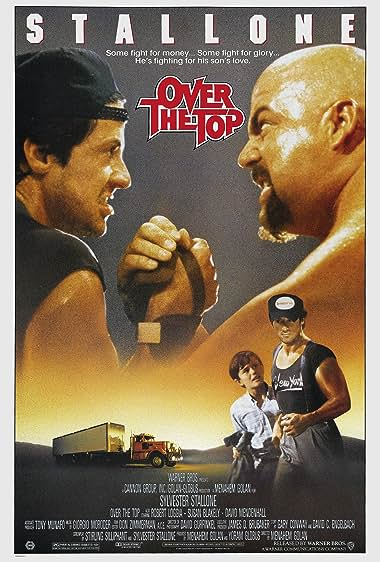


Description: Sylvester Stallone stars as hard-luck big-rig trucker Lincoln Hawk and takes us under the glaring Las Vegas lights for all the boisterous action of the World Armwrestling Championship. Relying on wits and willpower Hawk tries to rebuild his life by capturing the first-place prize money - and the love of the son he abandoned years earlier into the keeping of his his rich ruthless father-in-law.

Cast: Sylvester Stallone Robert Loggia Rick Zumwalt David Mendenhall Bruce Way
Director: Menahem Golan
Genres: Action Drama
Year: 1987

Score = 0.9354643

Movie title: Rambo III
IMDB ID: tt0095956


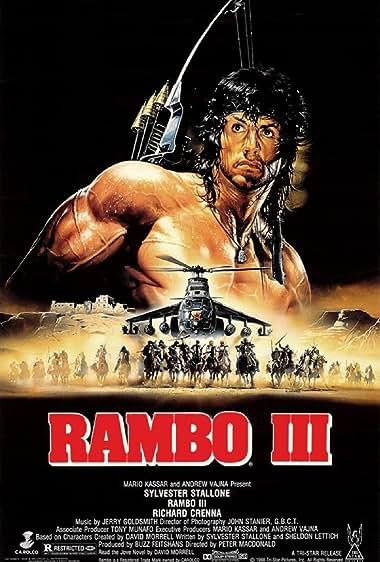


Description: Combat has taken its toll on Rambo but he's finally begun to find inner peace in a monastery. When Rambo's friend and mentor Col. Trautman asks for his help on a top secret mission to Afghanistan Rambo declines but must reconsider when Trautman is captured.

Cast: Sylvester Stallone Richard Crenna Kurtwood Smith Spiros FocÃ¡s Sasson Gabai
Director: Peter MacDonald
Genres: Action Adventure Thriller War
Year: 1988

Score = 0.95690125

Movie title: Lock Up
IMDB ID: tt0097770


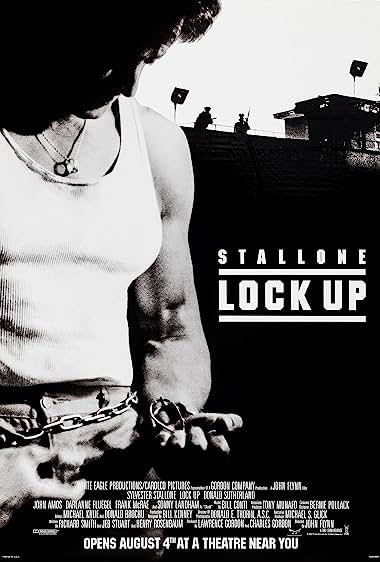


Description: Frank Leone is nearing the end of his prison term for a relatively minor crime. Just before he is paroled however Warden Drumgoole takes charge. Drumgoole was assigned to a hell-hole prison after his administration was publicly humiliated by Leone and has now arrived on the scene to ensure that Leone never sees the light of day.

Cast: Sylvester Stallone Donald Sutherland John Amos Sonny Landham Tom Sizemore
Director: John Flynn
Genres: Action Adventure Crime Drama Thriller
Year: 1989

Score = 0.91668034

Movie title: Tango & Cash
IMDB ID: tt0098439


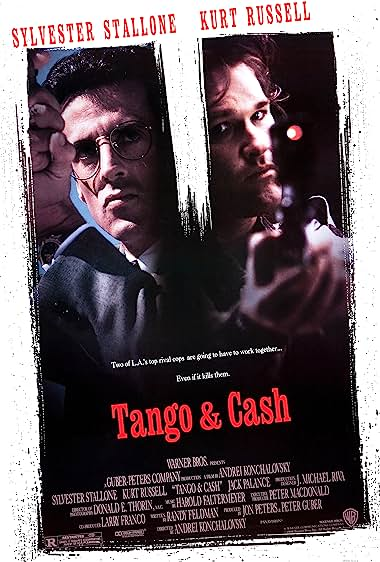


Description: Ray Tango and Gabriel Cash are narcotics detectives who while both being extremely successful can't stand each other. Crime Lord Yves Perret furious at the loss of income that Tango and Cash have caused him frames the two for murder. Caught with the murder weapon on the scene of the crime the two have no alibi. Thrown into prison with most of the criminals they helped convict it appears that they are going to have to trust each other if they are to clear their names and catch the evil Perret.

Cast: Sylvester Stallone Kurt Russell Teri Hatcher Jack Palance Brion James
Director: Andrei Konchalovsky Albert Magnoli
Genres: Action Adventure Comedy
Year: 1989

Score = 0.954674

Movie title: Rocky V
IMDB ID: tt0100507


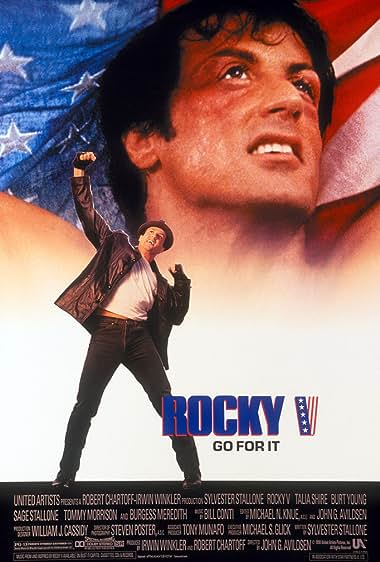


Description: A lifetime of taking shots has ended Rocky's career and a crooked accountant has left him broke. Inspired by the memory of his trainer however Rocky finds glory in training and takes on an up-and-coming boxer.

Cast: Sylvester Stallone Talia Shire Burt Young Sage Stallone Burgess Meredith
Director: John G. Avildsen
Genres: Drama
Year: 1990

Score = 0.93802106


In [52]:
get_acs_movies_results(movies_list)

In [53]:
get_all_trailers(movies_list)

"Rocky IV" (1985)

 https://www.youtube.com/watch?v=mIE5HYkzvV0


YouTube video comments for "Rocky IV" (1985) :

Comment 01: That vengeful look rocky gave drago after Apollo died to this day still gives me chills
Comment 02: Watching this at the age of 7 gave me goosebumps. Now at the age of 42 it still gives me goosebumps.
Comment 03: I am SO excited for the director's cut. I can't believe I'm this fired up for something that happened 35 years ago.
Comment 04: 2020 Y NO ME CANSO DE VERLA!!! Que actor Stallone!!!!
Comment 05: I cried when APOLLO died. If he dies he dies then Rocky and Drago stare at each other. It was on! Gave me chills. Best Rocky!
Comment 06: That shot of Apollo just falling straight down on the mat is epic.    Sad,  but epic
Comment 07: This has the greatest training montage of any movie on earth
Comment 08: That scene in 
Comment 09: Best of the best the 1985 version, thank you so much Sly for giving this movie to the world
Comment 10: This trailer is basically the entire movie in order...
Comment 11: This whole movie has the th

YouTube video comments for "Cobra" (1986) :

Comment 01: Best Stallone’s movie that he ever made anyone who hasn’t seen it is seriously missing out on a masterpiece movie of the great golden 80s.
Comment 02: This screams being a kid in the 90s watching TBS or the even USA up all night. I swear the 80s-90s were the golden years of action movies
Comment 03: I almost had to call an ambulance because I nearly had an 80s overdose watching this trailer.
Comment 04: This movie trailer will never be old. The whole song is a definition of BADASS 
Comment 05: I just watched this film. It was so thrilling and exciting. I was on the edge of my seat.
Comment 06: This movie never gets old
Comment 07: It’s crazy how much this movie was ahead of its time
Comment 08: I just discovered this trailer in 2021 and I'm over excited like it came out today. Stallone is the best and a genius
Comment 09: The original uncut version NEEDS TO BE RELEASED!!!!
Comment 10: "Cobra"(1986) is a good enough action thrille

YouTube video comments for "Over the Top" (1987) :

Comment 01: Watching this movie as a kid was a beautiful and healthy experience. Learned to be humble, to understand how to win and how to lose, to appreciate my family. Damn I miss these days, movies were so motivational. If I ever see Sly in front of me I will immediately thank him for this movie by kissing his mouth and then getting arrested.
Comment 02: As a 45 year old, this was the movie that always stuck with me, 80's at its best, amazing 
Comment 03: This is the film I grew up watching with my dad about 100 times
Comment 04: My little  brother and I watched this film everyday of the summer holidays one year  probably around '89. Absolute classic that brings back so many great memories.
Comment 05: I am 46 right now when i watched i was 12, .this kind of movie you never gonna see again...so amazing..so amazing music soundtrack..so amazing drama...so amazing 80s..
Comment 06: I don't care what ANYONE says, i love this film. I re

YouTube video comments for "Rambo III" (1988) :

Comment 01: essa tomada do tanque e do helicoptero, sem duvida é uma das melhores em todos os filmes. A adrenalina de um soldado tira completamente o medo da morte...se lança como uma fera contra o adeversário...ainda que morra, não imçporta, pois terá cumprido o seu dever de cpmbatente...sensacional essa parte do filme.
Comment 02: Galera... Sou Brasileiro e o Rambo foi um dos heróis da minha infância, me emociono quando vejo esses vídeos!
Comment 03: Such a cool movie. I remember walking to the theater to see it with my friends when I was a kid. "Drop your veapons." A line I remember all these years later.
Comment 04: Esse ator é muito bom todos os filmes dele e um espetáculo 
Comment 05: I was served in Afghanistan at the time and was blessed enough to have joined Rambo for this battle.  Actually I was the one who saved all the prisoners not Rambo.
Comment 06: Sylvester Stallone nasceu com talento e inteligência suficiente para ser um

YouTube video comments for "Lock Up" (1989) :

Comment 01: I used to watch this all the time as a kid. One of Stallone's best movies. Extremely underrated film.
Comment 02: Sonny Landham was in some of the best movies back in the days... 48 Hrs, Predator, Lock up. R.I.P. 
Comment 03: The good old days, when we used to watch real movies and real action heroes..They don't make movies like these any more...makes me sad.. 
Comment 04: The fight scene and the lift moment with stallone's eyes and the background music caught me each time ! Goosebumps !
Comment 05: Lock Up is one of the best movies of Stallone. He was such a good actor and a great action hero.And overall he was a very good looking actor too.
Comment 06: Hands down Stallone’s most underrated film.
Comment 07: One of the greatest films of all time. A masterpiece in every way.
Comment 08: Stallone does drama and violence so well, go Rocky go !!!
Comment 09: I don't care how few stars Stallone's movie get, he rocks.
Comment 10: A 

YouTube video comments for "Tango & Cash" (1989) :

Comment 01: The fact I know a lot of dialogs from this movie by heart, just proves how awesome this movie is. Brilliant!
Comment 02: They had such good chemistry!  Should have made a sequel immediately after.
Comment 03: "Well what do you know it's snowing"  Stallone is a legend.
Comment 04: It is always sad to see someone you know from a movie pass away, even if they are not the main actor, you still like them. Robert Z'dar is one missed. Rest In Peace Buddy.
Comment 05: "Rambo... is a pussy!" That was hilarious, coming from the actor who played Rambo.
Comment 06: One of the best action/comedy movies ever.
Comment 07: One of my all time favorite movies. I wouldn't be bored if I watch a thousand times.
Comment 08: Only in an 80's movie could someone stop a taker truck at full speed with a stub nosed 38 special.
Comment 09: RIP Robert Z'dar. He was really great guy. He created one of the most funny and iconic bad guy character.
Comment

YouTube video comments for "Rocky V" (1990) :

Comment 01: “My ring is outside”...that gives me goosebumps every time.  One of the best lines EVER!
Comment 02: Still one of my favourite Rocky films. I love that they took it back to Philly. Rocky 4, as much as it had a great cast, training montage(s) and fight, for me it’s the harsh reality of Philly and the rise of the underdog that makes these films special for me. I also love the Elton John signing on the end credits.
Comment 03: Rocky 5 is a masterpiece, the film has very few fights, but that makes it a dramatic masterpiece, Stallone's remebrance of his mentor in a lone boxing room is iconic
Comment 04: never forget being in the theater as an 8 year old, the crowd was cheering the final fight as if it was real
Comment 05: Rocky 5 is actually a good film!! Im a huge rocky fan and 5 fits in with the story of the "circle of life".for me its all part of the big picture
Comment 06: One of the most underrated movies ever. I really love th

### Test 3

In [54]:
prompt = "What are the top 3 movies about WW2 in terms of audience?\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: What are the top 3 movies about WW2 in terms of audience? I want you to save only the movie title in a numbered list with the release year.

Response: Sure, here are the top 3 movies about WW2 in terms of audience:

1. Saving Private Ryan (1998)
2. Schindler's List (1993)
3. Dunkirk (2017)

Powered by Azure AI
04-Sep-2023 13:04:27


In [55]:
movies_list = get_list(answer)

Movie 1: Saving Private Ryan (1998).
Movie 2: Schindler's List (1993).
Movie 3: Dunkirk (2017).



Movie title: Saving Private Ryan
IMDB ID: tt0120815


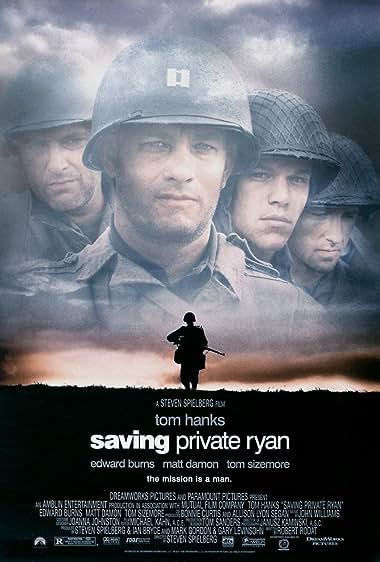


Description: As U.S. troops storm the beaches of Normandy three brothers lie dead on the battlefield with a fourth trapped behind enemy lines. Ranger captain John Miller and seven men are tasked with penetrating German-held territory and bringing the boy home.

Cast: Tom Hanks Tom Sizemore Dennis Farina Max Martini Joerg Stadler
Director: Steven Spielberg
Genres: Drama History War
Year: 1998

Score = 0.96176094

Movie title: Schindler's List
IMDB ID: tt0108052


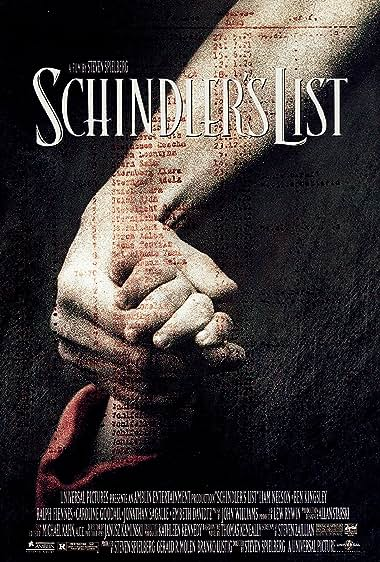


Description: The true story of how businessman Oskar Schindler saved over a thousand Jewish lives from the Nazis while they worked as slaves in his factory during World War II.

Cast: Liam Neeson Ben Kingsley Ralph Fiennes Caroline Goodall Jonathan Sagall
Director: Steven Spielberg
Genres: Drama History War
Year: 1993

Score = 0.95475453
Note: The movie Dunkirk (2017) is not available in the Azure Cognitive search index


In [56]:
get_acs_movies_results(movies_list)

In [57]:
get_all_trailers(movies_list)

Saving Private Ryan (1998)

 https://www.youtube.com/watch?v=9CiW_DgxCnQ


YouTube video comments for Saving Private Ryan (1998) :

Comment 01: I finally saw this film and wow... one of the most realistic war depictions I ever saw, thanks to Spielberg's oscar worthy directing! And of course... TOM HANKS WAS AMAZING IN THIS!
Comment 02: I can remember hearing about actual war vets having to leave the movie theater, because the movie was so realistic.
Comment 03: This is an intense movie. Spielberg is a cinematic genius at recreating history through film. His direction, the cinematography and John William's music is pure cinematic magic.
Comment 04: Just seen this movie. I am completely speechless can't describe in words how i am feeling after watching this masterpiece. This movie is absolutely   marvellous, after schindler's list this is the second movie made me cry. I want to give a big salute to the makers of this movie.
Comment 05: Even the trailer is a masterpiece.   How it builds the tempo, the slowing down of the scenes and the emotive music that dedicat

YouTube video comments for Schindler's List (1993) :

Comment 01: I remember my mother warning me against this movie. “It’s not that it’s a bad film.” She said. “It’s a masterpiece but the problem is, you can’t unsee it.”
Comment 02: This movie is a masterpiece in every sense. The acting is phenomenal, the cinematography is exceptional. Everything about this film is perfect.
Comment 03: The final science when he falls down in tears and all of them start to hug him to comfort him while he goes saying “I could have save more” in tears was the most human and heartwarming thing I have seen, truly a wonderful masterpiece this movie is
Comment 04: This is a true masterpiece. One of the most extraordinary and at the same time the saddest and disturbing movies of all times. I remember watching it a few years ago and needing to stop sometimes because I couldn’t bear the violence and the monstruosity of what I was seeing. I felt drained.
Comment 05: "I could've saved more.."
Comment 06: If we he

YouTube video comments for Dunkirk (2017) :

Comment 01: Dunkirk and 1917 makes you appreciate the life we live today. We must never forget. They are both masterpieces and deserve all the recognition.
Comment 02: Still believe Dunkirk is not just a movie.
Comment 03: I don’t understand why people hate this film so much. It’s not boring, it’s actually a masterpiece. Everything in this movie is perfect.
Comment 04: Extremely raw and realistic picture of a war which makes you feel you are there. Without unnecessary drama and individual heroism. Epic shots and music. This is why I adore Nolan.
Comment 05: I finally saw this film today. Haunting. Beautifully crafted and shot. What a masterpiece.
Comment 06: Honestly I don't care who stars in it, I can't wait for this movie. It will be amazing no doubt, in  Nolan we trust.
Comment 07: I LOVED this movie. Loved it. The filming, how it jumps back and forth with a weird timeline where you know something is going to happen before you actually re

### Test 4

In [58]:
prompt = "What is the name of the movie about two teenagers using a computer in the 80's?\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: What is the name of the movie about two teenagers using a computer in the 80's? I want you to save only the movie title in a numbered list with the release year.

Response: Here's a numbered list of the movie title and release year you're looking for:

1. WarGames (1983)

Powered by Azure AI
04-Sep-2023 13:04:39


In [59]:
movies_list = get_list(answer)

Movie 1: WarGames (1983).



Movie title: WarGames
IMDB ID: tt0086567


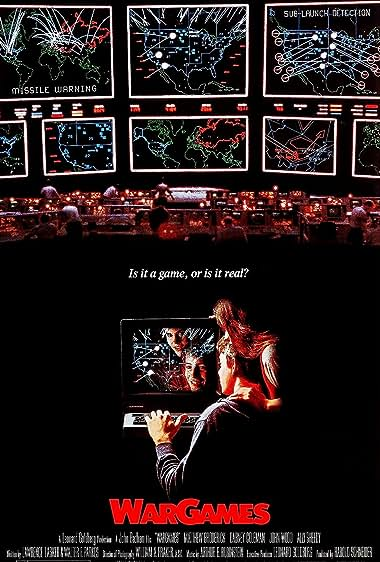


Description: High School student David Lightman (Matthew Broderick) has a talent for hacking. But while trying to hack into a computer system to play unreleased video games he unwittingly taps into the Defense Department's war computer and initiates a confrontation of global proportions Together with his girlfriend (Ally Sheedy) and a wizardly computer genius (John Wood) David must race against time to outwit his opponent...and prevent a nuclear Armageddon.

Cast: Matthew Broderick Dabney Coleman Ally Sheedy John Wood Barry Corbin
Director: John Badham
Genres: Thriller Science Fiction
Year: 1983

Score = 0.94630224


In [60]:
get_acs_movies_results(movies_list)

In [61]:
get_all_trailers(movies_list)

WarGames (1983)

 https://www.youtube.com/watch?v=TQUsLAAZuhU


YouTube video comments for WarGames (1983) :

Comment 01: Prolly one of the fondest movies of my childhood/midteens and I think the first time I seen a modem outside the geeky library at school :)
Comment 02: Great movie I just rewatched it for the first time in 10 years and it still holds up
Comment 03: With all the gadgets and all the tech nobody has made an A. I. Movie as this one. In the decade of throwbacks it would be cool to see Lawnmower Man with today's CGI.
Comment 04: One of my favorites.
Comment 05: He asked for a car, he got a computer. How's THAT for being born under a bad sign?
Comment 06: I asked ChatGPT "Shall we play a game?".
Comment 07: What a shame there doesn't seem to be any movie reboot or a sequel in the works anytime soon. Maybe, keep our fingers crossed. 
Comment 08: 0:11
Comment 09: I know some of these cult movies shouldn't been reboot it or remake it either but maybe putting a direct sequel out of it with the help from the people behind Mr Robot and some p

### Test 5

In [62]:
prompt = "What is the movie made by Steven Spielberg about crime prediction?\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: What is the movie made by Steven Spielberg about crime prediction? I want you to save only the movie title in a numbered list with the release year.

Response: 1. Minority Report (2002)

Powered by Azure AI
04-Sep-2023 13:04:44


In [63]:
movies_list = get_list(answer)

Movie 1: Minority Report (2002).



Movie title: Minority Report
IMDB ID: tt0181689


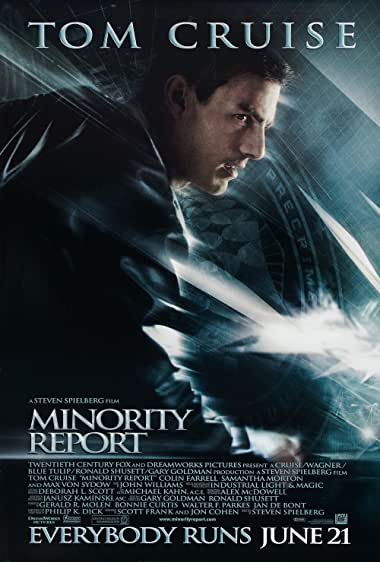


Description: John Anderton is a top "Precrime" cop in the late-21st century when technology can predict crimes before they're committed. But Anderton becomes the quarry when another investigator targets him for a murder charge. Can Anderton find a glitch in the system and prove his innocence before it's too late?

Cast: Tom Cruise Colin Farrell Samantha Morton Max von Sydow Lois Smith
Director: Steven Spielberg
Genres: Action Thriller Science Fiction Mystery
Year: 2002

Score = 0.9635283


In [64]:
get_acs_movies_results(movies_list)

In [65]:
get_all_trailers(movies_list)

Minority Report (2002)

 https://www.youtube.com/watch?v=lG7DGMgfOb8


YouTube video comments for Minority Report (2002) :

Comment 01: This movie is YEARS ahead of its time, plot wise, CGI wise, and everything else. It holds up SPECTACULARLY in 2021
Comment 02: I went to see this movie on the premiere date of June 17, 2002. It was amazing then, and in 2020 it still holds up quite well!! Mr. Spielberg is a genius, and all of his films are a treat to watch!!
Comment 03: The most realistic part about this movie is that the system only begins being questioned when rich and important people are targeted.
Comment 04: The first part really confused me but I understood why this movie is 2 hours and 30 mins long. They really took their time to explain everything and I eventually made me understand and the more I watch the more I get invested on what's gonna happen. Early 2000 films are really dominating in this type of genre when it comes to creativity and concept. I wish we can still have new movies with this kind of quality. I'll rate it 9/10.
Comment 05: I lov

## 6. Web apps

### 6.1 ChatGPT with azure Open AI webapp

In [66]:
def gradio_chatgpt_function(prompt, max_retries=3, retry_delay=1):
    """
    ChatGPT with Azure Open AI
    Input: prompt (string)
    Output: Azure Open AI ChatGPT results (string)
    """
    for _ in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                engine="gpt-35-turbo",  # Should be deployed in the AOAI studio
                messages=[
                    {
                        "role": "system",
                        "content": "You are an AI assistant that helps people to find \
                        information about movies. You will respond with the movie title name \
                        and the date of the released movie in a numbered list. \
                        One possible answer is : 1 Terminator (1984) 2 Mad Max (1979) 3 Abyss (1989)"
                    },
                    {"role": "user", "content": prompt},
                ],
                temperature=0.9,
                max_tokens=200,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0,
                stop=None,
            )
            resp = response["choices"][0]["message"]["content"]
            
            return resp

        except Exception as e:
            time.sleep(retry_delay)

    return None

In [67]:
logo = "https://github.com/retkowsky/images/blob/master/azure_openai_logo.png?raw=true"
image = "<center> <img src= {} width=500px></center>".format(logo)
header = "Azure ChatGPT Movie Application"
article = "Serge Retkowsky | Microsoft | 2023 | Powered by Azure Open AI"

samples = [
    "Show me some movies in NYC from the seventies",
    "Show me a list of movies like Terminator",
    "I want some musical movies",
    "Show me some movies like Jaws",
    "I want to see some movies with Stallone",
    "I love 'La folie des grandeurs'. What do you recommend me to watch?",
    "Display some movies names about dragons",
    "Display some movies names with hard rock bands",
]

inputs = gr.Textbox(lines=3, label="What do you want to search?")
outputs = gr.Textbox(label="Azure Open AI results")

azure_chatgpt_movie_webapp = gr.Interface(
    gradio_chatgpt_function,
    inputs,
    outputs,
    title=header,
    description=image,
    examples=samples,
    article=article,
    theme="gradio/monochrome",  # https://huggingface.co/spaces/gradio/theme-gallery
)

azure_chatgpt_movie_webapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://99adb49f51ae2b3de5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


### 6.2 ChatGPT with azure Open AI and Azure Cognitive Search webapp

In [68]:
def azure_chatgpt(prompt):
    """
    Azure Chat GPT to give movies answers from a prompt
    Input: prompt (string)
    Output: results (str)
    """
    response = openai.ChatCompletion.create(
        engine="gpt-35-turbo",  # Should be deployed in the AOAI studio
        messages=[
            {
                "role": "system",
                "content": "You are an AI assistant that helps people to find \
                information about movies. You must respond with a numbered list that contains \
                the movie title name and the date of the released movie. \
                If there is only one answer please add 1 before the movie title and the date. \
                When the answer is multiple you should have an example like that one: \
                Another possible answer is : 1 Terminator (1984) 2 Mad Max (1979) 3 Abyss (1989)"
            },
            {"role": "user", "content": prompt},
        ],
        temperature=0, # 
        max_tokens=800,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,)

    # Get only the movie(s)
    movies_titles = response["choices"][0]["message"]["content"]
    
    return movies_titles

In [69]:
def get_acs_infos(title):
    """
    Get the movies information from the title using Azure Cognitive Search
    Input: title movie (string)
    Output: results (text)
    """
    search_client = SearchClient(
        acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
    )

    vector = Vector(value=openai_text_embeddings(title), k=1, fields="embed_title")
    
    results = search_client.search(
        search_text=None,
        vectors=[vector],
        select=[
            "imdb_id",
            "title",
            "cast",
            "director",
            "description",
            "genres",
            "year",
        ],
        top=1,
    )

    for result in results:
        if result['@search.score'] >= 0.9:
            textresult = (
                f"{result['title']}  (score = {result['@search.score']})\n"
                f"Imdb id: {result['imdb_id']}\n"
                f"Description: {result['description']}\n"
                f"Director: {result['director']}\n"
                f"Cast: {result['cast']}\n"
                f"Genres: {result['genres']}\n"
                f"Year: {result['year']}\n\n"
            )
        else:
            #textresult = f"Note: the movie '{result['title']}' is not available in our vector database.\n"
            continue
        
        return textresult

In [70]:
def from_gpt_to_acs(gpt_result):
    """
    Generation of results to display for the webapp
    Input: movies list from azure open ai chatgpt (string)
    Output: results (string)
    """
    text_to_display = ''

    if gpt_result.count('\n') > 0:
        lines = gpt_result.splitlines()
        movies_list = []
        for line in lines:
            movies_list.append(line)
        
        # Doing the search in acs
        for movie in movies_list:
            infos = get_acs_infos(movie)
            text_to_display = text_to_display + str(infos)
    else:
        text_to_display = get_acs_infos(gpt_result)

    return text_to_display

In [71]:
def gradio_movieapp_function(prompt, topn=5):
    """
    Movie app with Azure Open AI and Azure Cognitive Search
    """   
    text_to_display = ''
    try:
        movies_titles = azure_chatgpt(prompt)
        text_to_display = from_gpt_to_acs(movies_titles)

    except Exception as e:
        pass
    
    return text_to_display

In [72]:
logo = "https://github.com/retkowsky/images/blob/master/movies_search.png?raw=true"
image = "<center> <img src= {} width=1000px></center>".format(logo)
header = "Movie Application using Azure Open AI and Azure Cognitive Search"
article = "Serge Retkowsky | Microsoft | 2023 | Powered by Azure Open AI and Azure Cognitive Search"

samples = [
    "Show me some movies in NYC from the seventies",
    "I want to see some movie with De Niro",
    "Show me some movies directed by Steven Spielberg",
    "Do you have some 'end of the world' movies?",
    "Show me some movies with a dragon",
    "Show me a movie where 2 teenagers where using a computer in the 80's",
    "Show me some James Bond movies with Sean Connery",
]

inputs = gr.Textbox(lines=3, label="What do you want to search?")
outputs = gr.Textbox(label="Azure Open AI and Azure Cognitive Search results")

azure_movie_webapp = gr.Interface(
    gradio_movieapp_function,
    inputs,
    outputs,
    title=header,
    description=image,
    examples=samples,
    article=article,
    theme="HaleyCH/HaleyCH_Theme",  # https://huggingface.co/spaces/gradio/theme-gallery
)

azure_movie_webapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://7aef5337ceedece12b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


> Go to the next notebook